## Process Description

![Dietician](Assets/Dietician.png)

Simulate a process of dietary consultation. People visit the clinic and see the consultant.

1. **Entity**: People arriving for dietary consultation
2. **Generator**: Generate arrivals for dietary consultation 
3. **Inter-Arrrival Time**: An exponential distribution sampled for patient arrivals  
4. **Activity**: Consultation with dietician
5. **Activity Time**: An exponential distribution sampled for consultation time
6. **Resources**: Dietician (1)
7. **Queues**: People waiting for consultation 
8. **Sink**: Exit after consultation

Based on: https://youtu.be/jXDjrWKcu6w

## Import packages

Aside from **simpy**, we need **random** to sample from random distributions and

In [102]:
import simpy
import random
import configuration

## Generate Arrivals

Define the generator for arrivals. This puts patients in the queue for consultation.

**Args**:
- env (Simpy environment) required
- mean_IAT (int) mean Inter-Arrival Time for generating arrivals
- mean_CT (int) mean consultation time
- dietician (Simpy resource) resource

**Notes**:
- Has a forever-while loop in which it:
	- Creates a patient ID and sends the patient onward on their journey, invoking the function that generates consultations with the patient's ID.
	- Has one ```yield``` statement to timeout for sampled Inter-Arrival Time, after which it increments patient ID. The ```yield``` with timeout will await the action (i.e. completion of timer), freezing until then and next resuming where it left off.


In [103]:
def generate_patient(env, mean_IAT, mean_CT, dietician):
    token_number = 0;

    # run indefintely
    while(True):
        # Send an arrival onward
        Consultation = generate_consultation(env, mean_CT, dietician, token_number)
        env.process(Consultation) 

        # Generate new arrival
        deltaIAT = random.expovariate(1.0 / mean_IAT)
        yield env.timeout(deltaIAT)

        token_number += 1

### Generate Consultations

Define the generator for consulation.

**Args**:
- env (Simpy environment) required
- mean_CT (int) mean consultation time
- dietician (Simpy resource)
- token_number (int) patient ID from the function that generates arrivals

**Notes**:
- Has a with statement for a resource with which it:
	- Has first yield statement to timeout until resource (nurse) is available
	- Has second yield statement to timeout for sampled processing time
	- Notes timestamps at: entered queue for resource (nurse), left queue, exited process.  

In [104]:
def generate_consultation(env, mean_CT, dietician, token_number):
    time_arrived = env.now
    print("Patient {} entered the queue at {:.2f}".format(token_number, time_arrived))

    with dietician.request() as req:
        # Wait until the dietician is available
        yield req

        time_consultation_started = env.now
        deltaQueued = time_consultation_started - time_arrived

        deltaCT = random.expovariate(1.0 / mean_CT)
        print("Patient {} entered consultation at {:.2f}, having waited {:.2f}".format(token_number, time_arrived, deltaQueued))
        yield env.timeout(deltaCT)


### Set Up Simulation

Define simulation variables as follows:
- Create an instance of env
- Initialize resources
- Define key parameters (for distributions)

In [105]:
# Set up the simulation environment
env = simpy.Environment()

# Set up the resources
dietician = simpy.Resource(env, 1)

# Configure simulation parameters
mean_IAT = 5 
mean_CT = 6



### Run Simulation

Run the simulation as follows:
- Register the function that generates arrivals with the environment
- Run simulation

In [106]:
# Make it so!
env.process(generate_patient(env, mean_IAT, mean_CT, dietician))
env.run(until=540)

Patient 0 entered the queue at 0.00
Patient 0 entered consultation at 0.00, having waited 0.00
Patient 1 entered the queue at 1.08
Patient 1 entered consultation at 1.08, having waited 1.19
Patient 2 entered the queue at 3.82
Patient 3 entered the queue at 6.79
Patient 4 entered the queue at 9.30
Patient 5 entered the queue at 12.93
Patient 2 entered consultation at 3.82, having waited 11.18
Patient 6 entered the queue at 18.22
Patient 3 entered consultation at 6.79, having waited 11.90
Patient 7 entered the queue at 20.65
Patient 4 entered consultation at 9.30, having waited 11.74
Patient 8 entered the queue at 21.91
Patient 9 entered the queue at 22.46
Patient 10 entered the queue at 29.69
Patient 11 entered the queue at 33.96
Patient 12 entered the queue at 34.29
Patient 13 entered the queue at 34.97
Patient 14 entered the queue at 43.95
Patient 15 entered the queue at 44.54
Patient 16 entered the queue at 45.61
Patient 17 entered the queue at 47.01
Patient 18 entered the queue at 4

## Part B: Scenario Planning

So far, we have simulated the consultation process. To apply this approach in sceario-planning, we will need to stash the results for presentation. We want to compare scenarios, ideally with multiple runs to have representative data for each. In this section, we will save simulation results and generate plots, using Pandas for data aggregation and Matplotlib for plotting. 

In [107]:
import simpy
import random
import configuration
from matplotlib import pyplot as plt

Rename and make no changes to the function to generate arrivals.

In [108]:
def generate_patient_mem(env, mean_IAT, mean_CT, dietician):
    token_number = 0;

    # run indefintely
    while(True):
        # Send an arrival onward
        Consultation = generate_consultation_mem(env, mean_CT, dietician, token_number)
        env.process(Consultation) 

        # Generate new arrival
        deltaIAT = random.expovariate(1.0 / mean_IAT)
        yield env.timeout(deltaIAT)

        token_number += 1

Rename and update the function to generate consultations to include global variables (lists) to persist data - timestamps and intervals. We want to know how long patients wait in queue. So we will use two global variables as follows:
- ```arrived``` (list) time of arrival for consultation
- ```queued``` (list) length of time in queue waiting for consultation

In [109]:
def generate_consultation_mem(env, mean_CT, dietician, token_number):
    global arrived
    global queued
    
    time_arrived = env.now
    print("Patient {} entered the queue at {:.2f}".format(token_number, time_arrived))

    with dietician.request() as req:
        # Wait until the dietician is available
        yield req

        time_consultation_started = env.now
        deltaQueued = time_consultation_started - time_arrived

        arrived.append(time_arrived)
        queued.append(deltaQueued)

        deltaCT = random.expovariate(1.0 / mean_CT)
        print("Patient {} entered consultation at {:.2f}, having waited {:.2f}".format(token_number, time_arrived, deltaQueued))
        yield env.timeout(deltaCT)

### Set up and run

Define the global variables and plot using matplotlib.

In [110]:
# Set up the simulation environment
env = simpy.Environment()

# Set up the resources
dietician = simpy.Resource(env, 1)

# Configure simulation parameters
mean_IAT = 5 
mean_CT = 6

# Set up the global variables
arrived = []
queued = []

# Make it so!
env.process(generate_patient_mem(env, mean_IAT, mean_CT, dietician))
env.run(until=540)

Patient 0 entered the queue at 0.00
Patient 0 entered consultation at 0.00, having waited 0.00
Patient 1 entered the queue at 9.57
Patient 1 entered consultation at 9.57, having waited 0.00
Patient 2 entered the queue at 14.81
Patient 2 entered consultation at 14.81, having waited 0.00
Patient 3 entered the queue at 16.31
Patient 4 entered the queue at 20.09
Patient 5 entered the queue at 20.61
Patient 6 entered the queue at 21.76
Patient 3 entered consultation at 16.31, having waited 5.77
Patient 7 entered the queue at 25.16
Patient 8 entered the queue at 25.66
Patient 9 entered the queue at 46.15
Patient 10 entered the queue at 47.68
Patient 11 entered the queue at 55.30
Patient 12 entered the queue at 57.15
Patient 4 entered consultation at 20.09, having waited 37.15
Patient 5 entered consultation at 20.61, having waited 37.70
Patient 6 entered consultation at 21.76, having waited 40.86
Patient 7 entered consultation at 25.16, having waited 41.58
Patient 13 entered the queue at 67.1

In [111]:
gantt = zip(arrived, queued)
g50 = list(gantt)[0:50]

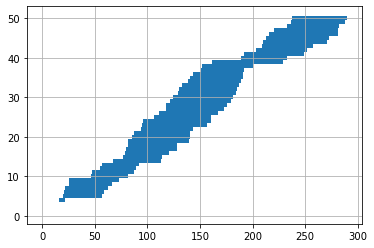

In [112]:
fig, gnt = plt.subplots()
gnt.grid(True)

idx_y = 0.5

for i in g50:
    gnt.broken_barh([i], (idx_y,1.0))
    idx_y += 1


## Homework Assignment

1. Enhance the plot, making at least two enhancements to clarify the message. Explain the enhancements and how they improve the message.
2. Notice the ```zip``` function returns a generator. We have forced it to a list. Doing so means we have access to the entire contents at once, whereas a generator only gives the next item upon request. But list is less efficient because entire contents are loaded into memory whereas we may only want to work with one item from the list at a time. Rewrite the plotting function with the generator. 

## Part C: Object Oriented Programming

So far we have simuulated a simple process. As process complexity increases and it has multiple steps, possibly sharing resources, with outages and other scenarios baked in the process characterization, we need to organize code better. We do this with Object Oriented Programming (OOP) where we divide responsibilities among classes. A class bundles data and methods into a package with logically coherent behavior. 